In [2]:
import uproot
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [188]:
with uproot.open("/home/users/aaarora/nvme/output/run2/sig.root") as f:
    df = f.get("Events").arrays([col for col in f.get("Events").keys() if "VBS" in col] + ["GenDeltaR1", "GenDeltaR2", "weight"], library="pd")

In [4]:
with uproot.open("/home/users/aaarora/nvme/output/run2/data.root") as f:
    df = f.get("Events").arrays([col for col in f.get("Events").keys() if "VBS" in col], library="pd")

In [9]:
df

,VBSMjj,VBSdetajj,VBSptjj,VBSjet2phi,VBSjet2pt,VBSjet1eta,VBSjet1pt,VBSjetidxs,VBSJets_mass,VBSJets_phi,VBSJets_eta,VBSjet1phi,VBSjet1mass,VBSjet2mass,goodVBSJets,VBSjet2eta,VBSJets_pt
0,2.825000e+01,3.288574e+00,1.606250e+02,-1.421387e+00,1.606250e+02,1.681558e-44,1.681558e-44,[-1 0],"[28.25, 6.95703125]","[-1.42138671875, -0.91943359375]","[3.28857421875, 3.400390625]",1.681558e-44,1.681558e-44,2.825000e+01,"[0, 0, 1, 0, 0, 1, 0, 0, 0]",3.288574e+00,"[160.625, 36.15625]"
1,4.265593e+02,4.206055e+00,1.120000e+02,-1.165039e+00,7.875000e+01,3.730957e+00,3.325000e+01,[2 1],"[18.40625, 14.6015625, 7.58203125]","[0.05078125, -1.1650390625, 1.364990234375]","[0.8656005859375, -0.47509765625, 3.73095703125]",1.364990e+00,7.582031e+00,1.460156e+01,"[0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]",-4.750977e-01,"[132.0, 78.75, 33.25]"
2,3.683630e+02,4.324188e+00,8.415625e+01,1.914795e+00,3.631250e+01,4.157227e+00,4.784375e+01,[1 2],"[18.140625, 9.5703125, 6.18359375]","[-1.04931640625, -1.8681640625, 1.914794921875]","[2.28369140625, 4.1572265625, -0.166961669921875]",-1.868164e+00,9.570312e+00,6.183594e+00,"[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]",-1.669617e-01,"[228.0, 47.84375, 36.3125]"
3,3.004688e+01,1.679199e+00,2.513750e+02,-1.761475e+00,2.513750e+02,1.681558e-44,1.681558e-44,[-1 0],"[30.046875, 4.5703125]","[-1.761474609375, -2.87353515625]","[1.67919921875, 2.30126953125]",1.681558e-44,1.681558e-44,3.004688e+01,"[0, 0, 1, 0, 0, 1, 0]",1.679199e+00,"[251.375, 42.4375]"
4,8.291804e+02,3.763184e+00,2.587500e+02,2.317383e+00,1.040000e+02,-2.250488e+00,1.547500e+02,[0 1],"[14.828125, 13.0390625, 8.78125]","[0.972900390625, 2.3173828125, -2.07421875]","[-2.25048828125, 1.5126953125, 1.4462890625]",9.729004e-01,1.482812e+01,1.303906e+01,"[0, 0, 1, 1, 0, 1, 0, 0, 0]",1.512695e+00,"[154.75, 104.0, 46.25]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12466,2.101948e-44,1.261169e-44,2.101948e-44,1.681558e-44,1.681558e-44,4.203895e-45,4.203895e-45,[-2 -1],"[13.6875, 6.80859375, 8.890625]","[-1.006591796875, -1.35205078125, 0.9332275390625]","[-3.291015625, -1.398193359375, -1.19970703125]",4.203895e-45,4.203895e-45,1.681558e-44,"[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1.681558e-44,"[58.40625, 41.34375, 34.0625]"
12467,8.381422e+01,1.599236e+00,7.259375e+01,-7.498741e-03,4.000000e+01,1.537598e+00,3.259375e+01,[2 1],"[11.8515625, 6.58203125, 5.2734375]","[2.69287109375, -0.007498741149902344, -1.63134765625]","[0.458740234375, -0.06163787841796875, 1.53759765625]",-1.631348e+00,5.273438e+00,6.582031e+00,"[0, 0, 0, 0, 1, 1, 1, 0, 0]",-6.163788e-02,"[52.09375, 40.0, 32.59375]"
12468,1.194211e+02,1.882080e+00,9.278125e+01,-9.848633e-01,4.521875e+01,1.197998e+00,4.756250e+01,[1 2],"[9.6484375, 5.75, 8.90625]","[-2.3505859375, 0.4822998046875, -0.98486328125]","[0.8597412109375, 1.197998046875, -0.68408203125]",4.822998e-01,5.750000e+00,8.906250e+00,"[0, 0, 0, 0, 1, 1, 1, 0]",-6.840820e-01,"[59.5625, 47.5625, 45.21875]"
12469,3.415625e+01,1.062927e-01,4.355000e+02,2.999115e-02,4.355000e+02,1.681558e-44,1.681558e-44,[-1 0],"[34.15625, 9.8984375]","[0.02999114990234375, 1.6650390625]","[0.106292724609375, 0.0933074951171875]",1.681558e-44,1.681558e-44,3.415625e+01,"[0, 1, 0, 0, 0, 1, 0, 0, 0]",1.062927e-01,"[435.5, 43.71875]"


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7ff0f715e090>, errorbar=None, legend_artist=None)]

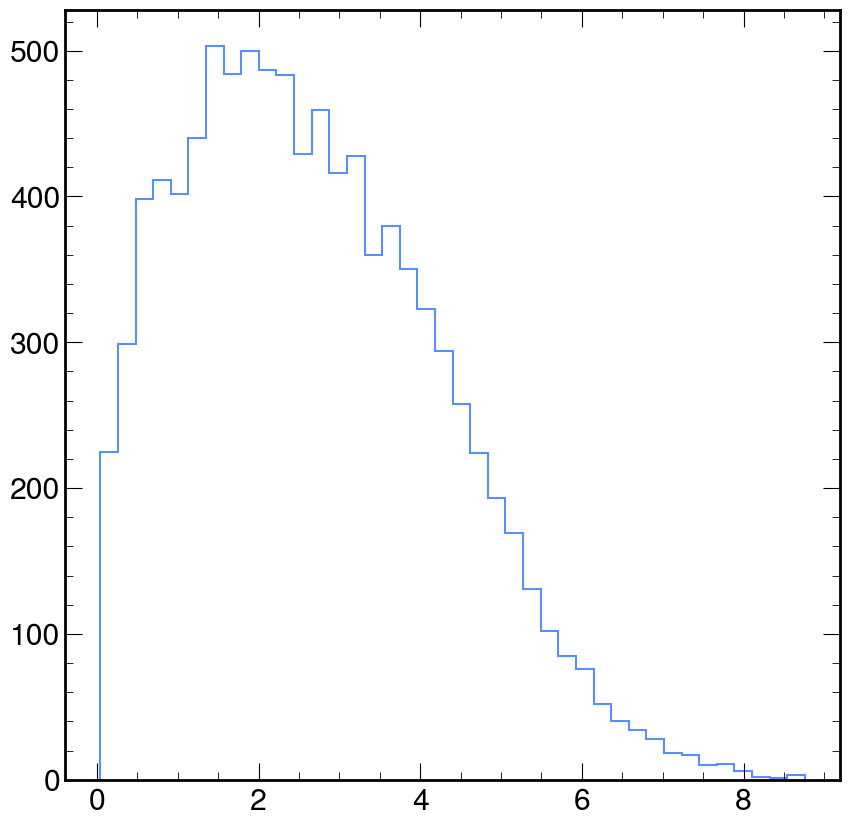

In [22]:
hep.histplot(np.histogram(df[df.VBSjet1eta * df.VBSjet2eta < 0].VBSdetajj, bins=40))

In [189]:
df[["GenDeltaR1", "GenDeltaR2", "TrueVBSJet1idx", "TrueVBSJet2idx"]]

,GenDeltaR1,GenDeltaR2,TrueVBSJet1idx,TrueVBSJet2idx
0,"[3.196406841278076, 3.3528096675872803, 4.285130023956299, 7.283416271209717, 0.035894691944122314, 7.353371620178223]","[4.329334259033203, 4.03207540512085, 3.66672945022583, 0.11388741433620453, 7.331027984619141, 0.6316060423851013]",4,3
1,"[3.827960729598999, 3.0572614669799805, 2.4224588871002197, 6.530063629150391, 0.04682590067386627, 0.7374122142791748, 3.446068286895752]","[4.201382160186768, 3.415804624557495, 4.590798377990723, 0.0806640237569809, 6.428288459777832, 7.189395904541016, 8.39810562133789]",4,3
2,"[5.8410725593566895, 5.232428550720215, 3.885000467300415, 8.667612075805664, 3.234156370162964, 0.05914555490016937, 2.936343193054199, 7.302043914794922]","[3.2019567489624023, 3.5262255668640137, 5.147008419036865, 0.029510876163840294, 5.607551097869873, 8.674029350280762, 5.7997307777404785, 1.9873921871185303]",5,3
3,"[4.348550796508789, 3.79032564163208, 5.427908897399902, 2.7039690017700195, 3.16144061088562, 0.04869387671351433, 3.9722721576690674, 4.768989562988281, 7.350991249084473, 5.906729698181152]","[2.825322389602661, 2.5687875747680664, 0.14837650954723358, 2.6357474327087402, 2.5987236499786377, 5.256516933441162, 3.0986135005950928, 0.5355977416038513, 2.0901873111724854, 1.7975043058395386]",5,2
4,"[3.361203670501709, 5.378451824188232, 5.171508312225342, 0.05620168149471283, 7.748459815979004, 5.793050289154053, 1.8891253471374512, 7.798855781555176]","[4.695863723754883, 2.326647996902466, 2.610382080078125, 7.633671283721924, 0.07725372910499573, 2.009702205657959, 5.927121162414551, 2.184896469116211]",3,4
...,...,...,...,...
17426,"[3.325735569000244, 3.4245595932006836, 4.8617329597473145, 2.904978036880493, 0.047076113522052765, 7.178948402404785, 8.002872467041016]","[5.066919326782227, 3.9906299114227295, 3.974215507507324, 5.251730442047119, 7.289219379425049, 0.2815125286579132, 0.8498073816299438]",4,5
17427,"[3.8985323905944824, 4.748938083648682, 6.455061912536621, 3.967296600341797, 6.565883636474609, 7.736208915710449, 0.0435044951736927, 8.733137130737305, 7.398675918579102, 8.003519058227539]","[4.035931587219238, 4.086607456207275, 2.999109983444214, 3.8373634815216064, 3.161168336868286, 0.02041787840425968, 7.783359050750732, 2.44684100151062, 0.8510677218437195, 1.1720750331878662]",6,5
17428,"[4.096776962280273, 3.529310464859009, 3.699587106704712, 0.06285201758146286, 6.437409400939941, 3.9695045948028564, 2.40374755859375, 7.795388221740723, 2.0962228775024414]","[4.055007457733154, 3.6102006435394287, 2.8144922256469727, 6.447901725769043, 0.02611391805112362, 3.928471326828003, 6.625324249267578, 3.177288055419922, 5.510824203491211]",3,4
17429,"[6.34552526473999, 6.578086853027344, 6.162002086639404, 5.345398426055908, 8.69324779510498, 10.454438209533691, 0.19114965200424194]","[4.566864490509033, 4.421547889709473, 4.762887477874756, 5.513264179229736, 2.115767002105713, 0.2943200170993805, 10.419476509094238]",6,5


In [190]:
maxE_eff = df[((df.TrueVBSJet1pt == df.VBSjet1pt) & (df.TrueVBSJet2pt == df.VBSjet2pt)) | ((df.TrueVBSJet1pt == df.VBSjet2pt) & (df.TrueVBSJet2pt == df.VBSjet1pt))].shape[0] / df.shape[0]

In [191]:
maxeta_eff = df[((df.TrueVBSJet1pt == df.VBSjet1pt_eta) & (df.TrueVBSJet2pt == df.VBSjet2pt_eta)) | ((df.TrueVBSJet1pt == df.VBSjet2pt_eta) & (df.TrueVBSJet2pt == df.VBSjet1pt_eta))].shape[0] / df.shape[0]

In [192]:
print("MaxE eff: ", maxE_eff)

MaxE eff:  0.8070104985370891


In [193]:
print("MaxEtaJJ eff: ", maxeta_eff)

MaxEtaJJ eff:  0.7725316964029603


In [3]:
with uproot.open("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_MVA_abcdnet.root") as f:
    df1 = f.get("Events").arrays(library="pd")

with uproot.open("/data/userdata/aaarora/output/run2/ABCDNet_simpleDisco_VBSVVH1lep_30/output/sig_LHEScaleWeight_muR_up_MVA_abcdnet.root") as f:
    df2 = f.get("Events").arrays(library="pd")

In [120]:
BDT_CUT = 0.56
DNN_CUT = 0.92

In [121]:
df3 = df1[(df1.VBSBDTscore > BDT_CUT) & (df1.abcdnet_score > DNN_CUT)]

In [122]:
df4 = df2[(df2.VBSBDTscore > BDT_CUT) & (df2.abcdnet_score > DNN_CUT)]

In [131]:
sum(df3.weight), sum(df4.weight)

(3.6522001873666485, 3.6522001873666485)

In [123]:
df1

,Hbbscore,HighestWjetScore,HbbPt,Hbbmass,MET,Mlbminloose,VBSBDTscore,VBSMjj,VBSdetajj,VBSjet1eta,VBSjet1phi,VBSjet1pt,VBSjet2eta,VBSjet2phi,VBSjet2pt,WjetPt,Wjetmass,leptonpt,weight,abcdnet_score
0,0.993688,0.995477,1336.00,92.8125,701.437866,1000.000000,0.669522,1.379572e+03,7.507812e+00,-3.874023e+00,3.337402e-01,3.064062e+01,3.633789e+00,2.554688e+00,3.406250e+01,538.5,87.4375,74.637367,0.000010,0.997815
1,0.992400,0.947796,392.25,120.7500,104.449089,1000.000000,0.788773,2.699342e+03,7.237305e+00,-3.946289e+00,5.872803e-01,7.481250e+01,3.291016e+00,-8.288574e-01,7.006250e+01,936.5,100.8750,170.314194,0.000071,0.856937
2,0.910465,0.940709,322.50,84.0625,144.256577,129.789078,0.292303,2.101948e-44,1.261169e-44,4.203895e-45,4.203895e-45,4.203895e-45,1.681558e-44,1.681558e-44,1.681558e-44,523.5,98.2500,43.511589,0.000044,0.057150
3,0.615827,0.998878,747.00,97.2500,56.530991,267.198853,0.509996,3.496895e+02,4.750244e+00,2.791992e+00,1.190674e+00,3.500000e+01,-1.958252e+00,2.680664e-01,3.050000e+01,726.5,96.5625,65.838402,0.000082,0.851753
4,0.741197,0.907364,335.25,133.2500,330.756042,52.523006,0.308440,6.722656e+00,1.154297e+00,1.154297e+00,-1.076416e+00,1.035625e+02,1.681558e-44,1.681558e-44,1.681558e-44,262.5,114.0625,103.506287,0.000075,0.069470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43951,0.986215,0.803009,395.50,121.0625,159.204071,1000.000000,0.742745,2.054569e+03,7.287598e+00,-4.228516e+00,-5.892334e-01,7.400000e+01,3.059082e+00,1.133789e+00,3.900000e+01,510.5,80.6875,495.017853,0.000140,0.994166
43952,0.983812,0.980755,361.75,123.9375,495.066132,1000.000000,0.790186,2.772308e+03,6.925781e+00,-3.041504e+00,-1.955566e+00,1.546250e+02,3.884277e+00,2.076660e+00,4.875000e+01,1096.0,80.1875,766.747253,0.000119,0.999508
43953,0.989948,0.987665,410.75,139.5000,195.381409,1000.000000,0.733977,1.734839e+03,6.776855e+00,-3.089844e+00,1.907715e+00,1.085625e+02,3.687012e+00,7.795410e-01,3.162500e+01,774.0,80.9375,364.023163,0.000100,0.995633
43954,0.999592,0.996523,1047.00,108.6875,446.798676,1000.000000,0.788773,2.354622e+03,7.456543e+00,-3.816895e+00,1.288086e+00,9.225000e+01,3.639648e+00,8.637695e-01,3.475000e+01,1209.0,96.6250,189.470673,0.000105,0.999203


In [124]:
df1 = df1.sort_values(["weight", "Hbbscore"]).reset_index(drop=True)
df2 = df2.sort_values(["weight", "Hbbscore"]).reset_index(drop=True)
df2.join(df1, lsuffix="_1", rsuffix="_2")[["Hbbscore_1", "Hbbscore_2", "VBSBDTscore_1", "VBSBDTscore_2"]].query("VBSBDTscore_1 != VBSBDTscore_2")

,Hbbscore_1,Hbbscore_2,VBSBDTscore_1,VBSBDTscore_2
479,0.970777,0.970777,0.742818,0.689524
480,0.970777,0.970777,0.689524,0.742818
677,0.987605,0.987605,0.704543,0.807185
678,0.987605,0.987605,0.807185,0.704543
695,0.988515,0.988515,0.322528,0.640279
696,0.988515,0.988515,0.640279,0.322528
778,0.992256,0.992256,0.717715,0.387788
779,0.992256,0.992256,0.387788,0.717715
806,0.992945,0.992945,0.531036,0.692994
807,0.992945,0.992945,0.692994,0.531036


In [125]:
df3 = df3.sort_values(["Hbbscore", "MET"]).reset_index(drop=True)
df4 = df4.sort_values(["Hbbscore", "MET"]).reset_index(drop=True)
df3.join(df4, lsuffix="_1", rsuffix="_2")[["Hbbscore_1", "Hbbscore_2", "weight_1", "weight_2"]].query("weight_1 != weight_2")

,Hbbscore_1,Hbbscore_2,weight_1,weight_2


In [126]:
df3

,Hbbscore,HighestWjetScore,HbbPt,Hbbmass,MET,Mlbminloose,VBSBDTscore,VBSMjj,VBSdetajj,VBSjet1eta,VBSjet1phi,VBSjet1pt,VBSjet2eta,VBSjet2phi,VBSjet2pt,WjetPt,Wjetmass,leptonpt,weight,abcdnet_score
0,0.500317,0.815629,821.0,91.7500,232.215012,1000.0,0.786421,3129.012939,8.430664,4.629883,0.090256,54.37500,-3.800781,-2.566895,39.25000,590.5,93.0625,57.528698,0.000067,0.967890
1,0.500455,0.986820,451.0,119.5625,533.306824,1000.0,0.792484,2722.925537,8.121582,4.139648,-0.915771,54.06250,-3.981934,1.568115,40.71875,606.5,82.8750,170.557846,0.000231,0.993379
2,0.500464,0.871713,963.5,85.2500,367.057007,1000.0,0.719691,1685.273682,7.535156,-3.836914,-2.345703,50.28125,3.698242,-2.889648,30.18750,1369.0,92.9375,158.911545,0.000068,0.997788
3,0.500471,0.982297,503.0,135.3750,81.649300,1000.0,0.560246,811.780884,5.321045,-3.674316,-1.523438,53.71875,1.646729,1.669189,59.31250,478.5,90.8125,251.395859,0.000137,0.971674
4,0.500546,0.893437,663.5,78.0625,906.116272,1000.0,0.807185,3934.764893,8.864258,4.356445,2.716797,62.93750,-4.507812,2.724121,34.78125,356.5,122.9375,95.611603,0.000104,0.950740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26432,0.999998,0.905431,1914.0,99.2500,512.731384,1000.0,0.706989,1994.001709,7.779785,-3.965332,-0.513794,49.62500,3.814453,2.475098,33.46875,777.5,81.8750,617.403748,0.000104,0.999676
26433,0.999998,0.892973,1156.0,127.1250,94.268005,1000.0,0.657713,2042.902100,5.725830,3.963867,-2.425781,50.50000,-1.761963,-2.334961,271.00000,1145.0,86.7500,77.317917,0.000091,0.995446
26434,0.999998,0.823345,1890.0,124.1250,616.205994,1000.0,0.771592,3075.814941,7.031738,-3.644531,-1.464600,97.81250,3.387207,-2.006836,85.56250,818.5,76.7500,567.959900,0.000104,0.999759
26435,0.999999,0.998936,2088.0,128.7500,55.284634,1000.0,0.728688,1434.940308,7.362793,4.083984,-0.948975,40.81250,-3.278809,-1.784912,32.03125,1993.0,85.8125,1451.847778,0.000116,0.999926


In [127]:
df4

,Hbbscore,HighestWjetScore,HbbPt,Hbbmass,MET,Mlbminloose,VBSBDTscore,VBSMjj,VBSdetajj,VBSjet1eta,VBSjet1phi,VBSjet1pt,VBSjet2eta,VBSjet2phi,VBSjet2pt,WjetPt,Wjetmass,leptonpt,weight,abcdnet_score
0,0.500317,0.815629,821.0,91.7500,232.215012,1000.0,0.786421,3129.012939,8.430664,4.629883,0.090256,54.37500,-3.800781,-2.566895,39.25000,590.5,93.0625,57.528698,0.000067,0.967890
1,0.500455,0.986820,451.0,119.5625,533.306824,1000.0,0.792484,2722.925537,8.121582,4.139648,-0.915771,54.06250,-3.981934,1.568115,40.71875,606.5,82.8750,170.557846,0.000231,0.993379
2,0.500464,0.871713,963.5,85.2500,367.057007,1000.0,0.719691,1685.273682,7.535156,-3.836914,-2.345703,50.28125,3.698242,-2.889648,30.18750,1369.0,92.9375,158.911545,0.000068,0.997788
3,0.500471,0.982297,503.0,135.3750,81.649300,1000.0,0.560246,811.780884,5.321045,-3.674316,-1.523438,53.71875,1.646729,1.669189,59.31250,478.5,90.8125,251.395859,0.000137,0.971674
4,0.500546,0.893437,663.5,78.0625,906.116272,1000.0,0.807185,3934.764893,8.864258,4.356445,2.716797,62.93750,-4.507812,2.724121,34.78125,356.5,122.9375,95.611603,0.000104,0.950740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26432,0.999998,0.905431,1914.0,99.2500,512.731384,1000.0,0.706989,1994.001709,7.779785,-3.965332,-0.513794,49.62500,3.814453,2.475098,33.46875,777.5,81.8750,617.403748,0.000104,0.999676
26433,0.999998,0.892973,1156.0,127.1250,94.268005,1000.0,0.657713,2042.902100,5.725830,3.963867,-2.425781,50.50000,-1.761963,-2.334961,271.00000,1145.0,86.7500,77.317917,0.000091,0.995446
26434,0.999998,0.823345,1890.0,124.1250,616.205994,1000.0,0.771592,3075.814941,7.031738,-3.644531,-1.464600,97.81250,3.387207,-2.006836,85.56250,818.5,76.7500,567.959900,0.000104,0.999759
26435,0.999999,0.998936,2088.0,128.7500,55.284634,1000.0,0.728688,1434.940308,7.362793,4.083984,-0.948975,40.81250,-3.278809,-1.784912,32.03125,1993.0,85.8125,1451.847778,0.000116,0.999926


In [128]:
sum(df1.weight)

6.216145223876482

In [129]:
sum(df2.weight)

6.216145223876482

In [130]:
with uproot.open("/ceph/cms/store/user/aaarora/VBS_1lep_skims/sig_1lep_4ak4_or_1ak8_2ak4_v1/RunIISummer20UL16NanoAODAPVv9/VBSWWH_OSWW_MJJ-100_4f_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v2/281000/skimmed/output_merged2.root") as f:
    df = f.get("Events").arrays(["event"], library="pd")

In [18]:
with uproot.open("/data/userdata/aaarora/output/run2/test_jec_absolute_up.root") as f:
    df1 = f.get("Events").arrays(library="pd")

with uproot.open("/ceph/cms/store/user/legianni/skimNano-TestUL__TEST-SamplesV9_Addendum/GluGluToBulkGravitonToHHTo2G2Tau_M-1000_narrow_TuneCP5_13TeV-madgraph-pythia8/reskimNano-UL_RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2_MINIAODSIM_v0/231025_002252/0000/tree_1.root") as f:
    df2 = f.get("Events").arrays(library="pd")

df1 = df1.sort_values(["event"]).reset_index(drop=True)
df2 = df2.sort_values(["event"]).reset_index(drop=True)

In [19]:
df1[["event", "CorrJet_pt"]]

,event,CorrJet_pt
0,3,"[251.0585174560547, 192.92288208007812, 111.45121765136719, 50.1099853515625, 24.03347396850586, 24.01093101501465]"
1,4,"[390.28369140625, 365.5478515625, 103.42656707763672, 83.07290649414062, 61.04463577270508, 18.833906173706055]"
2,5,"[390.5345153808594, 273.1756591796875, 139.65643310546875, 113.0819091796875, 26.34721565246582]"
3,6,"[379.7490539550781, 335.6038513183594, 192.90365600585938, 67.42202758789062, 23.322050094604492, 16.34124183654785, 16.201126098632812, 15.866196632385254]"
4,8,"[351.6566467285156, 346.3893127441406, 228.1480712890625, 181.25350952148438, 47.21932601928711, 38.235782623291016, 33.62596893310547, 19.209016799926758, 18.461681365966797]"
...,...,...
76626,99994,"[394.04608154296875, 193.4053497314453, 69.81796264648438, 34.26372528076172, 33.96066665649414, 21.87421226501465, 19.32086753845215, 18.413164138793945, 16.019319534301758]"
76627,99995,"[505.36199951171875, 130.25186157226562, 105.82905578613281, 84.4380874633789, 39.766937255859375, 26.562955856323242, 20.523799896240234]"
76628,99997,"[464.06866455078125, 367.4586181640625, 160.84292602539062, 56.716888427734375, 53.52470016479492, 38.71638870239258]"
76629,99998,"[316.80267333984375, 264.8976135253906, 127.63892364501953, 58.99018096923828, 33.138572692871094, 33.15531921386719, 19.901744842529297, 16.767597198486328, 16.428176879882812]"


In [20]:
df2[["event", "Jet_pt_jesAbsoluteUp"]]

,event,Jet_pt_jesAbsoluteUp
0,3,"[253.48452758789062, 194.369873046875, 113.39523315429688, 52.182682037353516, 24.096158981323242, 22.655803680419922]"
1,4,"[391.3318176269531, 371.6882019042969, 104.41727447509766, 83.78219604492188, 62.57596969604492, 18.460140228271484]"
2,5,"[394.6015625, 277.7295227050781, 138.4053955078125, 114.7370376586914, 27.1494197845459]"
3,6,"[382.2220458984375, 339.8795471191406, 198.04920959472656, 68.39798736572266, 23.360984802246094, 16.974552154541016, 14.769576072692871, 9.156697273254395]"
4,8,"[356.2401123046875, 352.2860412597656, 230.4981231689453, 179.7022247314453, 45.82438659667969, 37.58558654785156, 33.77814865112305, 28.474178314208984, 20.48811912536621]"
...,...,...
76626,99994,"[399.5522155761719, 195.1356201171875, 69.98448944091797, 34.64440155029297, 32.869686126708984, 15.700623512268066, 23.587160110473633, 19.513011932373047, 15.578592300415039]"
76627,99995,"[510.3081970214844, 130.8912811279297, 104.09949493408203, 83.37897491455078, 39.80754852294922, 26.367717742919922, 28.560014724731445]"
76628,99997,"[469.0876770019531, 371.13055419921875, 163.29537963867188, 57.785987854003906, 53.04030990600586, 38.954036712646484]"
76629,99998,"[320.5044250488281, 268.1943054199219, 129.39816284179688, 59.61988830566406, 32.17466354370117, 32.64902114868164, 17.47662925720215, 15.050878524780273, 13.99685001373291]"
